<span style="font-size:12px">

#### 2025-11-13 
- Seq2Seq(Sequence-to-Sequence) 문제 정의와 해결 전략 이해
- 기본 순환신경망(RNN) 한계와 LSTM 개선 아이디어 파악
- Encoder-Decoder 구조의 정보 흐름(컨텍스트 벡터/숨겨진 상태) 이해
- Teacher Forcing 기법의 학습 안정화 역할 및 Trade-off 이해
- Softmax와 CrossEntropy 손실의 수식 및 직관적 해석
- Inference 단계(그리디 vs 빔 서치)의 실전 활용 전략
- 전체 파이프라인을 하나의 흐름으로 연결하여 종합 정리

<span style="font-size:12px">
------------------------

#### Seq2Seq(Sequence-to-Sequence) 모델은 입력 시퀀스를 받아서, 출력 시퀀스를 생성하는 구조

| 단계 | 이름               | 하는 일                    | 비유                     |
| -- | ---------------- | ----------------------- | ---------------------- |
| 1  | **전처리**          | 문자를 숫자로 바꿔서 벡터로 만듦      | “단어장을 만들어 문장을 숫자로 바꾸기” |
| 2  | **인코더(Encoder)** | 입력 문장을 읽고 의미를 압축        | “사람이 전체 문장을 이해하는 단계”   |
| 3  | **디코더(Decoder)** | 그 의미를 바탕으로 출력 문장 생성     | “이해한 내용을 새로운 언어로 말하기”  |
| 4  | **학습 모델(Model)** | 인코더+디코더 연결 → 학습 가능하게 구성 | “전체 통역 훈련 시스템”         |


<span style="font-size:12px">
-------------------------------------------

#### >>> seq2seq (모델 구조 (프레임워크))
- “입력 시퀀스를 받아서 출력 시퀀스로 바꿔주는” 신경망 구조
- 자연어 처리(NLP)에서 번역기, 요약, 질의응답, 챗봇 등에 아주 자주 쓰임
- 영문장을 한국어로 번역,질의 ----> 답변생성, 문장 요약 등
- 필요성
    - 입력과 출력의 길이가 다를 수 있는 문제 (번역, 요약, 챗봇)
    - 고정크기의 피처벡터(평균임베딩 등)는 순서정보와 문맥관계를 충분히 반영하지 못함
        (RNN/LSTM/GRU/Transformer 같은 순차 모델은 이 순서와 문맥을 모델링)
    - 단순 분류모델은 시퀀스 간 종속성 생성(토큰별 점진적 예측)에 부적합
- 동작원리
    - 1. Encoder : 입력토큰들을 순차적으로 처리 → RNN(LSTM/GRU)에 넣음 → 마지막 hidden state = 문장의 의미 요약
    - 2. Context (요약표현) : 인코더의 정보를 압축
    - 3. Decoder : context + 이전에 생성한 토큰을 이용해서 다음 토큰을 반복생성
  <br>           : Encoder의 요약 벡터를 받아 → RNN으로 단어를 하나씩 출력 (start → 단어들 → end)
    - 4. 종료 : 특별한 EOS 토큰이 나올 때카지
        입력: "I love you"
        ↓
        Encoder RNN → [context vector]
        ↓
        Decoder RNN → "나는", "너를", "사랑해"
- 실제 사용예시
    - 번역, 대화시스템, 문서요약, 코드자동생성, 챗봇, 자막생성


    입력 시퀀스 x1, x2, ..., x_Tenc
            ↓ Encoder
      hidden states h1, h2, ..., h_Tenc
            ↓ (context)
        context (vector) or set of hi
            ↓ Decoder (step-by-step)
      y1 -> y2 -> y3 -> ... -> y_Tdec

<span style="font-size:12px">
-------------------------------------------

- 학습용 영어-프랑스어 병렬 문장 데이터 준비
- 개념: 
   - 입력(영어)과 출력(프랑스어) 쌍으로 구성
   - 디코더 입력에는 시작 토큰(\t), 타겟에는 종료 토큰(\n) 추가
- 설명:
   - input_texts: 인코더에 입력될 영어 문장
   - target_texts: 디코더가 생성해야 할 프랑스어 문장 (전처리 포함)

In [2]:
import numpy as np
import tensorflow as tf

data_pairs = [
    ("Hello", "Bonjour"),
    ("How are you", "Comment allez-vous"),
    ("Good morning", "Bonjour matin"),
    ("Thank you", "Merci"),
]

# 입력과 타겟을 분리
input_texts = []
target_texts = []
for eng, fra in data_pairs:
    input_texts.append(eng)
    # 디코더 입력 '\t'(시작), 디코더 출력:'\n' (종료)
    target_texts.append(f'\t{fra}\n')      #('\t' + fra + '\n')
for i in range(len(input_texts)):
    print(f"입력: {input_texts[i]:20s} --> 타겟 : {target_texts[i]}")


입력: Hello                --> 타겟 : 	Bonjour

입력: How are you          --> 타겟 : 	Comment allez-vous

입력: Good morning         --> 타겟 : 	Bonjour matin

입력: Thank you            --> 타겟 : 	Merci



<span style="font-size:12px">
-------------------------------------------

- 문자 단위 사전(vocabulary) 생성 및 정수 인덱스 변환
- 개념:
    - 각 문자를 고유한 정수로 매핑
    - 입력과 타겟의 사전은 별도 관리
    - 원-핫 인코딩으로 신경망 입력 형태 생성
- 설명:
    - input_characters: 영어 문장에 등장하는 모든 고유 문자
    - target_characters: 프랑스어 문장 + 특수 토큰(\t, \n)
    - encoder_input_data: 3D 배열 (샘플, 시퀀스 길이, 문자 사전 크기)

In [3]:
########### 실습1-1. 
# seq2seq 모델을 학습하기 위한 입력데이터 전처리 과정
# 이 코드는 문자 단위 번역기(Seq2Seq) 를 만들기 위해,
# 문자 → 숫자 변환 + 원핫 인코딩 + 입력/출력 분리(Teacher Forcing) 를 하는 데이터 준비 단계

# 1. 입력과 타겟의 고유한 문자 수집
input_characters = set()
target_characters = set()
# for text in input_texts:
#     for char in text :
#         input_characters.add(char)
#----> list comprehention
input_characters = {char for text in input_texts for char in text}
target_characters = {char for target_texts in target_texts for char in target_texts}
#모든 입력 문장(input_texts)에 등장하는 고유한 문자들을 모아요.
#| 예시                                              | 결과                                                             |
#| ------------------------------------------------- | -------------------------------------------------------------- |
#| input_texts = ["hi", "bye"]                       | {'h', 'i', 'b', 'y', 'e'}                                      |
#| target_texts = ["\t salut \n", "\t au revoir \n"] | {'\t', ' ', 'a', 'u', 's', 'l', 't', 'v', 'o', 'i', 'r', '\n'} |



# 2. 정렬해서 일관성 확보 : 항상 같은 순서로 문자 인덱스를 부여해서 재현성(reproducibility) 보장
# 상기 set으로 모으기 때문에 순서가 없음. 그래서 알파벳 순서대로 정렬해서 리스트로 변경
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))



# 3. 문자개수 * 문장길이 계산 ===> 이걸 알아야 3D배열의 크기(모양)를 미리 만들수 있음
# 3-1. 문자개수 계산
num_encoder_tokens = len(input_characters) # 입력문장에서 쓸 수 있는 문자 종류수
num_decoder_tokens = len(target_characters) # 출력문장에서 쓸 수 있는 문자 종류수

# 3-2. 가장 긴 문장 길이 계산
max_encoder_seq_length = max(len(text) for text in input_texts) 
max_decoder_seq_length = max(len(text) for text in target_texts)



# 4-1. 문자 --> 인덱스 매핑
input_token_index = {char : i for i, char in enumerate(input_characters)}
target_token_index = {char : i for i, char in enumerate(target_characters)} 

# 4-2. 인덱스 --> 문자 역매핑(추론시 사용)
reverse_input_token_index = {idx:char for char,idx in input_token_index.items()}
reverse_target_token_index = {idx:char for char,idx in target_token_index.items()}



# 5-1. 원핫 인코딩 배열 준비
# encoder_input_data : 3D 배열 (샘플, 시퀀스 길이, 문자 사전 크기)
# 예시
# encoder_input_data = np.zeros((10,20,30))
# encoder_input_data, encoder_input_data.shape

encoder_input_data = np.zeros( (len(input_texts), max_encoder_seq_length, 
                                num_encoder_tokens), dtype='float32')
# 모델에 넣는 실제 입력 (시작토큰 포함한 타겟 문장)
decoder_input_data = np.zeros( (len(input_texts), max_decoder_seq_length, 
                                num_decoder_tokens), dtype='float32')
# 정답 데이터 (한 타임스텝 뒤로 밀린게 정답 --> 이래야 모델이 이전 문자를 보고 다음문자를 예측하도록 배움 --> Teacher Forcing)
decoder_target_data = np.zeros( (len(input_texts), max_decoder_seq_length, 
                                 num_decoder_tokens), dtype='float32')

# 문자별 원핫 인코딩 실제 채우기 : 실제 문자를 숫자(벡터)로 바꾸는 핵심
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    
    for t, char in enumerate(target_text):
       #decoder_input_data: 전체 타겟 시퀀스 (시작 토큰 포함)
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        
       #decoder_target_data: 한 타임스텝 앞선 정답 (Teacher Forcing용)
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        # 예시 설명
        # hi 입력
        # \t hello 디코더 입력
        # hello \n 디코더 출력 - Teacher Forcing 한스텝 앞으로 이동



print(f'고유 입력 문자수 : {num_encoder_tokens}')
print(f'고유 타겟 문자수 : {num_decoder_tokens}')
print(f'최대 입력 문장길이 : {max_encoder_seq_length}')
print(f'최대 타겟 문장길이 : {max_decoder_seq_length}')
print(f'===== (샘플, 시퀀스 길이, 문자사전 크기)')
print(f'encoder_input_data : {encoder_input_data.shape}')
print(f'decoder_input_data : {decoder_input_data.shape}')
print(f'decoder_target_data: {decoder_target_data.shape}')

고유 입력 문자수 : 19
고유 타겟 문자수 : 22
최대 입력 문장길이 : 12
최대 타겟 문장길이 : 20
===== (샘플, 시퀀스 길이, 문자사전 크기)
encoder_input_data : (4, 12, 19)
decoder_input_data : (4, 20, 22)
decoder_target_data: (4, 20, 22)


<span style="font-size:12px">
-----------------------------

- LSTM 기반 Seq2Seq 인코더-디코더 학습 모델 구축
- 개념:
    - Encoder: 입력 시퀀스를 처리하고 최종 상태(h, c) 출력
    - Decoder: Encoder 상태를 초기값으로 받아 타겟 시퀀스 생성
    - return_state=True: LSTM 내부 상태(h, c) 반환
    - return_sequences=True: 모든 타임스텝 출력
- 설명:
    - encoder_states: [h, c] (hidden state, cell state)
    - decoder_lstm: 초기 상태로 encoder_states 전달
    - decoder_dense: Softmax로 각 타임스텝의 문자 확률 분포 생성


---------------------------------------- 하기 셀 코드 참조
------------ 실습1-2. 모델설계

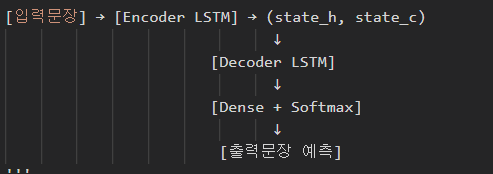



- 1. Encoder (입력문장을 읽는 부분) 

| 코드                 | 설명                              | 비유                           |
| ------------------ | ------------------------------- | ---------------------------- |
| `encoder_inputs`   | 입력 데이터를 받는 자리                   | "영어 문장을 입력받을 마이크"            |
| `LSTM(latent_dim)` | 문장을 순서대로 읽으며 기억                 | “단어를 읽고 문맥을 머리에 저장하는 사람”     |
| `state_h, state_c` | 마지막 시점의 **은닉상태(h)**, **셀상태(c)** | “문장을 다 읽고 머릿속에 남은 핵심 의미 요약본” |
| `encoder_states`   | 디코더에게 전달할 정보                    | “통역사에게 전달되는 문맥(컨텍스트)”        |

<br>

- 2. Decoder (새 문장을 만들어 내는 부분)

| 코드                                   | 설명                               | 비유                          |
| ------------------------------------ | -------------------------------- | --------------------------- |
| `decoder_inputs`                     | 시작 토큰(`\t`)부터 실제 출력(`\n`)까지의 시퀀스 | “통역사가 첫 단어(시작 신호)부터 말하기 시작” |
| `decoder_lstm`                       | 이전 단어를 보고 다음 단어를 예측              | “지금까지 말한 내용+컨텍스트로 다음 단어 생각” |
| `initial_state=encoder_states`       | 인코더의 문맥정보를 전달받음                  | “입력 문장의 의미를 알고 말하기 시작”      |
| `Dense(num_decoder_tokens, softmax)` | 다음 글자(혹은 단어) 확률 출력               | “다음 단어 후보 중 가장 가능성 높은 걸 선택” |

<br>

- 3. model 전체학습 모델 연결

| 항목 | 의미                                               |
| -- | ------------------------------------------------ |
| 입력 | `[encoder_inputs, decoder_inputs]` → 인코더와 디코더 입력 |
| 출력 | `decoder_outputs` → 실제 우리가 맞추려는 타겟 시퀀스           |
| 역할 | 인코더 + 디코더를 한 번에 학습할 수 있도록 연결                     |


In [4]:
########### 실습1-2.
### 모델 설계

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense


latent_dim = 256  # LSTM 은닉 차원 (내부 표현 크기)

# ==================== Encoder ====================
encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_input')
encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# Encoder : 입력문장을 읽는 부분
# LSTM은 시퀀스를 “기억하면서 읽는” 신경망이에요.
# state_h: 지금까지 읽은 정보 중 “단기기억” (즉시 사용하는 상태)
# state_c: 장기기억(기억저장소 같은 것)

# encoder_outputs는 사용하지 않고, 내부 상태(state_h, state_c)만 디코더로 전달
# 입력시퀀스를 LSTM에 통과시켜서 마지막 은닉상태(state_h)와 셀상태(state_c)를 받아서
# 두 상태는 입력문장의 의미(context)를 압축한 벡터
encoder_states = [state_h, state_c]



# ==================== Decoder ====================
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_input')
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')

# 디코더 초기 상태로 인코더 최종 상태 사용 (컨텍스트 전달)
# 인코더의 상태(state_h, state_c)를 초기상태로 받아서 자신의 입력 decoder_inputs을 기반으로
# 다음단어를 예측 --> 각 시점의 출력은 Dense+softmax를 거쳐서 단어(문자) 확률 분포로 예측
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# 각 타임스텝에서 문자 확률 분포 생성
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)




#  ==================== 학습 모델 ====================
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='seq2seq_training')

print("\n🏗️ 모델 구조:")
model.summary()


🏗️ 모델 구조:


Model: "seq2seq_training"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None, 19)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None, 22)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    282,624 │ encoder_input[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    285,696 │ decoder_input[0]… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None, 22)  │      5,654 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 573,974 (2.19 MB)

 Trainable params: 573,974 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

<span style="font-size:12px">
--------------------------------------------

- 목적: Seq2Seq 모델 컴파일 및 학습 실행
- 개념:
    - categorical_crossentropy: 다중 클래스(문자 사전) 손실
    - Teacher Forcing: decoder_input_data는 정답 시퀀스 전체 제공
    - 학습 목표: decoder_target_data (한 타임스텝 앞당긴 정답)
- 설명:
    - optimizer='rmsprop': 순환신경망에 안정적인 최적화 알고리즘
    - epochs=100: 작은 데이터셋이므로 충분한 반복 필요
    - batch_size=2: 메모리 효율 (실제로는 전체 4개 샘플 사용)

In [5]:
########### 실습1-3 
### 학습 / 여기서 코드 수정 후 본 셀만 실행하면 epochs 200되는 것이되므로, 위에 모델도 다시 실행시켜주기

# model.compile() : 신경망을 "학습할 준비 상태로 만드는" 단계
model.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)
history = model.fit(
    [encoder_input_data, decoder_input_data], #seq2seq 구조특성으로 X를 쌍으로 데이터를 받음.
    decoder_target_data,  # Y
    batch_size= 2,
    epochs = 500,  #자연어 100번 기본
    # validation_split = 0.0, #데이터셋이 작아서 분할안함
    verbose = 0 # 0은 출력안하고 1은 간단하게 2는 좀더 출력
)

In [6]:
history.history['acc'][-1]

0.4124999940395355

<span style="font-size:12px">
--------------------- 실습 1-4 추론 모델 구축---------

- 학습된 가중치를 사용해 실제 번역용 추론 모델 구축
- 핵심 개념:
    - Encoder 모델: 입력 → 내부 상태 추출
    - Decoder 모델: 이전 상태 + 현재 입력 → 다음 문자 예측
    - 추론 시에는 Teacher Forcing 없이 자기 예측을 다음 입력으로 사용
- 설명:
    - encoder_model: 입력 문장 → [h, c] 상태 출력
    - decoder_model: 한 타임스텝씩 반복 실행
    - 각 스텝에서 가장 높은 확률의 문자 선택 (Greedy Decoding)

In [7]:
########### 실습1-4 추론 모델 구축

# encoder 추론 모델
encoder_model = Model(encoder_inputs, encoder_states, name="encoder_inference")

# decoder 추론 모델
# 이전 타임스텝의 상태를 입력으로 받음
decoder_state_input_h = Input(shape=(latent_dim, ), name="decoder_state_h")
decoder_state_input_c = Input(shape=(latent_dim, ), name="decoder_state_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# LSTM 실행 (이전상태 + 현재입력)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]

# 문자 확률 분포 생성
decoder_outputs = decoder_dense(decoder_outputs)

# 모델
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states,
    name= 'decoder_inference'
)


<span style="font-size:12px">
-------------------------- 실습 1-5 구현 및 테스트 --------

- 입력 문장을 번역하는 디코딩 함수 구현 및 테스트
- 개념:
    - Greedy Decoding: 매 스텝 가장 높은 확률 문자 선택
    - 종료 조건: '\n' 토큰 생성 또는 최대 길이 도달
    - 자기회귀적 생성: 이전 예측을 다음 입력으로 반복 사용
- 설명:
    1. Encoder로 입력 문장의 상태 벡터 추출
    2. 시작 토큰('\t')으로 Decoder 시작
    3. 반복: 현재 문자 예측 → 다음 입력으로 사용
    4. '\n' 만나면 종료

In [8]:
############ 실습 1-5 구현

def decode_sequence(input_seq):
    """
    입력 시퀀스(원-핫 인코딩)를 받아 번역된 문자열 반환
    """
    # 1단계: Encoder로 상태 벡터 추출
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    # 2단계: 디코더 시작 토큰 준비 ('\t')
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.0
    
    # 3단계: 문자를 하나씩 생성
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        # 현재 문자 예측 + 다음 상태 업데이트
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )
        
        # 가장 높은 확률의 문자 선택 (Greedy)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        
        # 문자 추가
        decoded_sentence += sampled_char
        
        # 종료 조건 체크
        if sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        
        # 다음 스텝 준비: 현재 예측을 다음 입력으로
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        
        # 상태 업데이트
        states_value = [h, c]
    
    return decoded_sentence

In [9]:
############ 실습 1-6 테스트 예시
for seq_index in range(len(input_texts)):
    # 원핫인코딩 입력 추출
    input_seq = encoder_input_data[seq_index: seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq)
    print(decoded_sentence)
    break

[[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
Bonjour



In [10]:
############ 실습 1-6 테스트 최종
for seq_index in range(len(input_texts)):
    # 원핫인코딩 입력 추출
    input_seq = encoder_input_data[seq_index: seq_index+1]
    decoded_sentence = decode_sequence(input_seq)

    # 시작/종료 토큰 제거
    decoded_sentence = decoded_sentence.replace('\t', '').replace('\n','')
    print(f'입력문장 : {input_texts[seq_index]}')
    print(f'정답문장 : {target_texts[seq_index][1:-1]}') #시작종료토큰제거
    print(f'모델예측 : {decoded_sentence}')
    print('================================')
    

입력문장 : Hello
정답문장 : Bonjour
모델예측 : Bonjour
입력문장 : How are you
정답문장 : Comment allez-vous
모델예측 : Comment alllll
입력문장 : Good morning
정답문장 : Bonjour matin
모델예측 : Bonjour  maal
입력문장 : Thank you
정답문장 : Merci
모델예측 : Merci


In [11]:
print(history.history['acc'][-1])

0.4124999940395355
